### Tensorflow tutorial and doodling
- This code generously, and shamelessly... borrowed, from: https://www.tensorflow.org/tutorials
- Basic Tensorflow-fu (or is it -foo?)
- Some simple classifiers, regressors, etc. 
- Largely, use this to test TF installations.

The example sets up a simple multi-layer NN to classifiy a standard set of images. The base example uses simple, fully connected layers. We extend this base example to include one or more convolutional layers, which improves both the accuracy and performance consistency (over multiple iterations of the model).

Note for workingon shared resources (aka, tool-servers), it is polite (and consistent with policy) to limit the number of compute cores.


In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
#

In [2]:
import os
#os.system('source module lcuda/cuda-9.0oad')
import sys

print('ex: ', sys.executable)

ex:  /Users/myoder96/anaconda3/bin/python


In [3]:
#from __future__ import absolute_import, division, print_function, unicode_literals

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy
np = numpy
#import numpy as np
import matplotlib.pyplot as plt

print('TensorFlow version: {}'.format(tf.__version__))
print('TF is_built_with_cuda: ', tf.test.is_built_with_cuda())
print('TF GPU available: {}'.format(tf.test.is_gpu_available()))

TensorFlow version: 1.13.1
TF is_built_with_cuda:  False
TF GPU available: False


In [4]:
import scipy
import pylab as plt
import matplotlib as mpl
import itertools


### Load some image data
- Standard image data set of clothing items

In [5]:
fashion_mnist = keras.datasets.fashion_mnist
#
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()


In [6]:
# We can call these anything, though it is (relatively) important to choose the
#. right number of classes.
#
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [7]:
# Some properties of the data:
print('shapes: ', train_images.shape, train_labels.shape)
print('shapes: ', test_images.shape, test_labels.shape)

shapes:  (60000, 28, 28) (60000,)
shapes:  (10000, 28, 28) (10000,)


In [8]:
# Count objects. numpy.bincount() is probably the bastest way to do this, though it needs to be
#. validadated. Most likely, the values are in sorted order, but we really don't know, right?
#
# numpy.bincount is a nice find:
X = numpy.random.randint(0,3, 25)
print('X :', X)
print('X-counts: \n', numpy.array([numpy.unique(X), numpy.bincount(X)]).T)
#
print('bin_count training: \n', numpy.array([numpy.unique(train_labels), numpy.bincount(train_labels)]).T)
#


X : [2 0 1 1 1 2 1 2 0 0 1 1 2 0 0 1 0 2 0 1 1 1 0 2 2]
X-counts: 
 [[ 0  8]
 [ 1 10]
 [ 2  7]]
bin_count training: 
 [[   0 6000]
 [   1 6000]
 [   2 6000]
 [   3 6000]
 [   4 6000]
 [   5 6000]
 [   6 6000]
 [   7 6000]
 [   8 6000]
 [   9 6000]]


### Plot some of the images, for reference

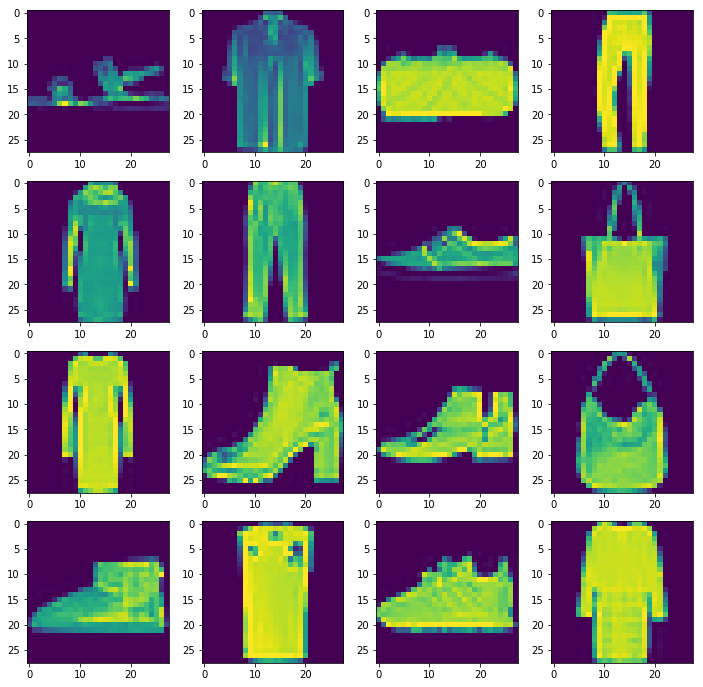

In [9]:
plt.figure(figsize=(12,12))
#
n_col = 4
n_rw  = 4
#
for j,k in itertools.product(range(n_col), range(n_rw)):
    ax = plt.subplot(n_col, n_rw, j*n_rw + k + 1)
    ax.imshow(train_images[numpy.random.randint(len(train_images))])
    #ax.colorbar()
    #
    ax.grid(False)
#plt.show()

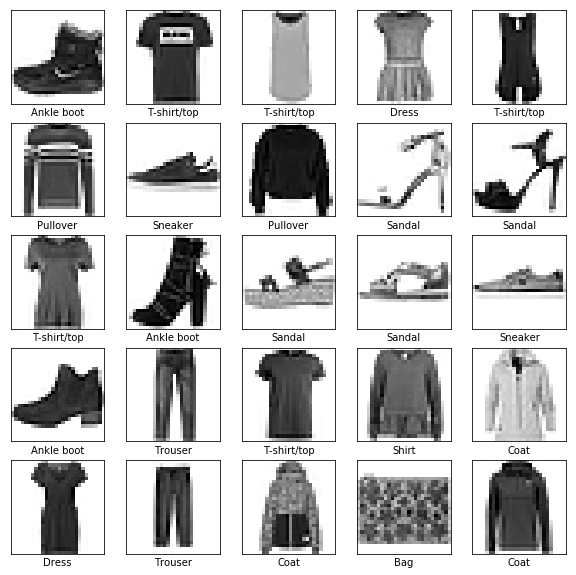

In [10]:
train_images = train_images/255.
test_images  = test_images/255.
#
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])
plt.show()

### Do some TensorFlow:
- Enable parallel CPU computation
- Because we might run on shared resrouce, add parameter to limit the resources we will use

- Configure a session
- Build a model
- Train, predict, evaluate

In [11]:
# set up Tensorflow sessin() ???
#. we want to be sensitive to running on the tool servers; do we need to limit the number
#  of cores we use?
n_cpu   = 1
n_cores = 8
#
# sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True, 
#                                        log_device_placement=True))
#
# NOTE: the precise configuration might vary a bit. be careful to not give a configuration that 
#.  is incompatible with the hardware and confuses TF (use the Google to better understand how
#.  sensitive TF will be)
config = tf.ConfigProto(intra_op_parallelism_threads=n_cores, inter_op_parallelism_threads=n_cores, \
                        allow_soft_placement=True, device_count = {'CPU': n_cpu})
session = tf.Session(config=config)
#K.set_session(session)
#



In [12]:
# Build the model:
#
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(128, activation=tf.nn.relu),
    keras.layers.Dense(10, activation=tf.nn.softmax)
])
#
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
#
model.summary()
#
model.fit(train_images, train_labels, epochs=5)
#
test_loss, test_acc = model.evaluate(test_images, test_labels)
#
print('Test accuracy: {}, Loss: {}'.format(test_acc, test_loss))

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               100480    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1290      
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
60000/60000 [==============================] - 4s 59us/sample - loss: 0.5047 - acc: 0.8214
Epoch 2/5
60000/60000 [==============================] - 3s 46us/sample - loss: 0.3752 - acc: 0.8647
Epoch 3/5
60000/60000 [==============================] - 3s 43us/sample - loss: 0.3355 - acc: 0.8781
Epoch 4/5
60000/60000 [==

In [13]:
#
predictions = model.predict(test_images)
#
print('predictions[0]: ', predictions[0])
np.argmax(predictions[0])
#
test_labels[0]


predictions[0]:  [2.2349088e-05 1.7706783e-07 1.5640733e-05 3.8430137e-08 4.5011643e-06
 7.5807072e-02 1.5747943e-05 1.3156965e-01 3.5518166e-05 7.9252923e-01]


9

In [14]:
def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  
  plt.imshow(img, cmap=plt.cm.binary)
  
  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'
  
  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array[i], true_label[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)
  
  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

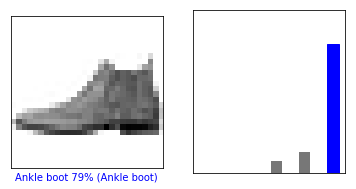

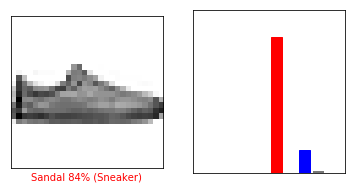

In [15]:
i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions,  test_labels)
plt.show()
#
i = 12
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions,  test_labels)
plt.show()

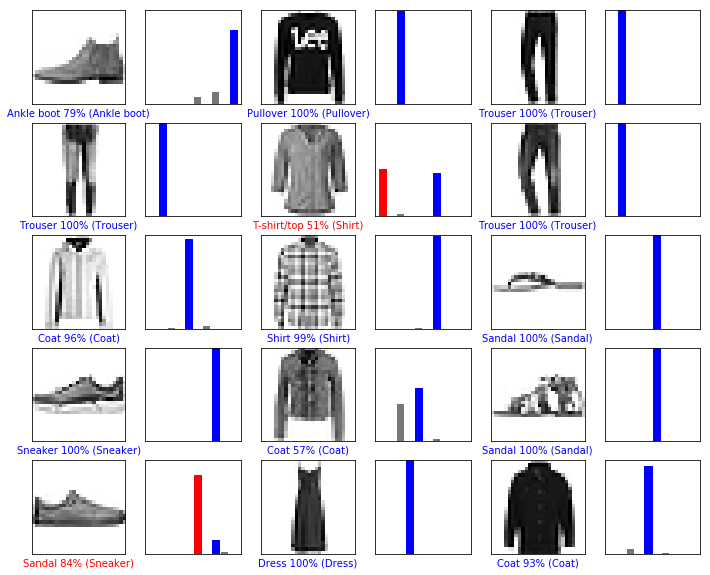

In [16]:
# Plot the first X test images, their predicted label, and the true label
# Color correct predictions in blue, incorrect predictions in red
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions, test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions, test_labels)
plt.show()

In [17]:
# In earlier tests on this, TF performance with just fully connected layers was hit and miss.
# Sometimes we'd get 80-90% success; other times much much less, with high variability on
# the success metric.
#
#. Not surprisingly, adding a convolutional layer (or two) significantly improved performance
#. and perormance consistency.
#
# We don't seem to be observing this here, but we want to demonstrate the convolutional layer anyway.
#
# Rebuild the model; add one or more Conv2D layers to the front (is that the top or the bottom?)
# prams: filters: number of filters/components, kernel_size: window size, strides: steps in (x,y),
#.  ... and some others.
#
# reshape images arrays to reflect color channels; in this case, there is one channel.
#. should we be doing this, generally, for the fully-connected layers as well?
#
train_images_conv = train_images.reshape((60000, 28, 28, 1))
test_images_conv  = test_images.reshape((10000, 28, 28, 1))
#
# 
# Build the model:
#
model = keras.Sequential([
    keras.layers.Conv2D(filters=32, kernel_size=(3, 3), strides=(1,1), activation='relu',
                        use_bias=True, dilation_rate=(1,1),
                        input_shape=(28, 28, 1)
                       ),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(filters=64, kernel_size=(3, 3), strides=(1,1), activation='relu',
                        use_bias=True, dilation_rate=(1,1)
                       ),
    keras.layers.MaxPooling2D((2, 2)),
    #
    #keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation=tf.nn.relu),
    keras.layers.Dense(10, activation=tf.nn.softmax)
])
#
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
#
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1600)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               204928    
_________________________________________________________________
dense_3 (Dense)              (None, 10)                1290      
Total para

In [18]:
#
model.fit(train_images_conv, train_labels, epochs=5)
#
test_loss, test_acc = model.evaluate(test_images_conv, test_labels)
#
print('Test accuracy: {}, Loss: {}'.format(test_acc, test_loss))

Epoch 1/5
60000/60000 [==============================] - 27s 442us/sample - loss: 0.4560 - acc: 0.8353
Epoch 2/5
60000/60000 [==============================] - 26s 438us/sample - loss: 0.3079 - acc: 0.8866
Epoch 3/5
60000/60000 [==============================] - 26s 427us/sample - loss: 0.2584 - acc: 0.9043
Epoch 4/5
60000/60000 [==============================] - 25s 416us/sample - loss: 0.2255 - acc: 0.9169
Epoch 5/5
10000/10000 [==============================] - 1s 95us/sample - loss: 0.2525 - acc: 0.9086
Test accuracy: 0.9085999727249146, Loss: 0.252470061314106


### GPU Available?
- Is one or more GPU available?
- Also confirm that TF was built with cuda

In [19]:
print('is_built_with_cuda: ', tf.test.is_built_with_cuda())
print(tf.test.is_gpu_available(cuda_only=False) )



is_built_with_cuda:  False
False
